## 0- Importing the necessary libraries:

In [165]:
import re
import pymongo
import nltk
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np 
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models.word2vec import LineSentence

## Part 1 : Rule Based NLP and Regex:

In [38]:
# Define the text provided by the user
text = "I bought three Samsung smartphones 150 $ each, four kilos of fresh banana for 1,2 dollar a kilogram and one Hamburger with 4,5 dollar."

# Define a regular expression pattern to extract product information
pattern = r"(?P<quantity>\d+|\b(?:one|two|three|four|five|six|seven|eight|nine|ten)\b)\s*(?:kilos? of)?\s*(?:fresh )?(?P<product>[a-zA-Z\s]+?)(?: for| with)?\s*(?:\d+\s*(?:dollar|$))?\s*(?:\d+\s*(?:dollar|$))?(?P<unit_price>[\d.,]+)\s*(?:dollars?|each)?"

# Dictionary to convert words to numbers
word_to_num = {
    "one": 1,
    "two": 2,
    "three": 3,
    "four": 4,
    "five": 5,
    "six": 6,
    "seven": 7,
    "eight": 8,
    "nine": 9,
    "ten": 10
}

# Define a list to store bill entries
bill_entries = []

# Find all matches in the text based on the regex pattern
matches = re.finditer(pattern, text, re.IGNORECASE)

# Process each match
for match in matches:
    # Get the matched groups
    quantity = match.group("quantity")
    product = match.group("product").strip()
    unit_price = match.group("unit_price").replace(",", ".")  # Replace commas with periods for float conversion
    
    # Convert quantity to integer
    if quantity.isdigit():
        quantity = int(quantity)
    else:
        quantity = word_to_num[quantity.lower()]
    
    # Convert unit price to float
    unit_price = float(unit_price)
    
    # Calculate total price
    total_price = quantity * unit_price
    
    # Append the information to the bill entries list
    bill_entries.append((product, quantity, unit_price, total_price))

# Print the generated bill
print("Generated Bill:")
print("{:<20} {:<8} {:<10} {:<10}".format("Product", "Quantity", "Unit Price", "Total Price"))
for entry in bill_entries:
    product, quantity, unit_price, total_price = entry
    print(f"{product:<20} {quantity:<8} {unit_price:<10.2f} {total_price:<10.2f}")


Generated Bill:
Product              Quantity Unit Price Total Price
Samsung smartphones  3        150.00     450.00    
banana               4        1.20       4.80      
Hamburger            1        4.50       4.50      


## Part 2 : Word Embedding :

### 0. Organizing data from lab1 :

In [86]:
# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017")

In [87]:
db = client["atelier1"]

In [88]:
collection = db["arabicdata"]

In [92]:
for document in collection.find().limit(1):
    arabictext = document['content']

In [93]:
print(arabictext)

سيف قبل ساعات من مقتله
كان سيف على موعد للخروج من غزة في الأسبوع التالي لوفاته، متجها إلى دولة الإمارات ليتقدم لخطبة فتاة، لكنه قُتل خلال قصف إسرائيلي لقافلة إغاثية في قطاع غزة.
وسيف هو الفلسطيني الوحيد الذي قُتل ضمن سبعة موظفين للمطبخ العالمي المركزي في قطاع غزة، بينما كان الآخرون يحملون جنسيات أجنبية متعددة.
يقول عصام أبو طه، والد سيف: "ظهرت أسماؤنا في التنسيق الأمني للخروج من غزة، كنا سنذهب للإمارات أنا وسيف ووالدته لنخطب له، كان فرحا بهذه الخطوة، لكن لا أحد يمكنه منع القدر".
الهجوم الذي وقع الأسبوع الماضي أثار حالة واسعة من الغضب في الأوساط الدولية، واعتذر عنه الجيش الإسرائيلي.
"إذا نسي العالم سيف سيظل موجودا في قلوبنا"، يقول شقيقه عبد الرازق أبو طه في مكالمة هاتفية مع بي بي سي، حيث يحكي عن أخيه بكثير من الفخر، وفي ذات الوقت الأسى لفقدانه.
قصص مقترحة نهاية
كان سيف على موعد للخروج من غزة في الأسبوع التالي لوفاته
اسمه سيف أبو طه يبلغ من العمر 25 عاماً، ولد في قطاع غزة ثم انتقل للدراسة والعمل في الإمارات، تخرج في جامعة عجمان وعاش هناك لفترة.
عاد سيف من الإمارات إلى القطاع قبل نحو ثلاث

In [176]:
# Text Cleaning
def clean_text1(text):
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Removing punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    # Removing English letters and numbers
    text = re.sub(r'[a-zA-Z0-9]', '', text)
     # Removing new lines and carriage returns, replace them with a space
    text = re.sub(r'[\n\r]+', ' ', text)
    # multiple spaces into One
    text = re.sub(r'\s+', ' ', text)
    return text
def clean_text2(text):
    # Removing HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Removing English letters and numbers
    text = re.sub(r'[a-zA-Z0-9]', '', text)
     # Removing new lines and carriage returns, replace them with a space
    text = re.sub(r'[\n\r]+', ' ', text)
    # multiple spaces into One
    text = re.sub(r'\s+', ' ', text)
    # Use a regular expression to remove all characters except for . and ,
    text = re.sub(r'[^.,\n\s\w]', '', text)
    return text
arabictext1 = clean_text1(arabictext)
arabictext2 = clean_text2(arabictext)
print(arabictext1)

سيف قبل ساعات من مقتله كان سيف على موعد للخروج من غزة في الأسبوع التالي لوفاته متجها إلى دولة الإمارات ليتقدم لخطبة فتاة لكنه قتل خلال قصف إسرائيلي لقافلة إغاثية في قطاع غزة وسيف هو الفلسطيني الوحيد الذي قتل ضمن سبعة موظفين للمطبخ العالمي المركزي في قطاع غزة بينما كان الآخرون يحملون جنسيات أجنبية متعددة يقول عصام أبو طه والد سيف ظهرت أسماؤنا في التنسيق الأمني للخروج من غزة كنا سنذهب للإمارات أنا وسيف ووالدته لنخطب له كان فرحا بهذه الخطوة لكن لا أحد يمكنه منع القدر الهجوم الذي وقع الأسبوع الماضي أثار حالة واسعة من الغضب في الأوساط الدولية واعتذر عنه الجيش الإسرائيلي إذا نسي العالم سيف سيظل موجودا في قلوبنا يقول شقيقه عبد الرازق أبو طه في مكالمة هاتفية مع بي بي سي حيث يحكي عن أخيه بكثير من الفخر وفي ذات الوقت الأسى لفقدانه قصص مقترحة نهاية كان سيف على موعد للخروج من غزة في الأسبوع التالي لوفاته اسمه سيف أبو طه يبلغ من العمر عاما ولد في قطاع غزة ثم انتقل للدراسة والعمل في الإمارات تخرج في جامعة عجمان وعاش هناك لفترة عاد سيف من الإمارات إلى القطاع قبل نحو ثلاثة أعوام حين افتتحت العائلة مشر

In [101]:
# Tokenization
nltk.download('punkt') 
arabicwords = word_tokenize(arabictext1)
arabicsents = sent_tokenize(arabictext2)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [106]:
print(arabicsents)

['سيف قبل ساعات من مقتله كان سيف على موعد للخروج من غزة في الأسبوع التالي لوفاته متجها إلى دولة الإمارات ليتقدم لخطبة فتاة لكنه قتل خلال قصف إسرائيلي لقافلة إغاثية في قطاع غزة.', 'وسيف هو الفلسطيني الوحيد الذي قتل ضمن سبعة موظفين للمطبخ العالمي المركزي في قطاع غزة بينما كان الآخرون يحملون جنسيات أجنبية متعددة.', 'يقول عصام أبو طه والد سيف ظهرت أسماؤنا في التنسيق الأمني للخروج من غزة كنا سنذهب للإمارات أنا وسيف ووالدته لنخطب له كان فرحا بهذه الخطوة لكن لا أحد يمكنه منع القدر.', 'الهجوم الذي وقع الأسبوع الماضي أثار حالة واسعة من الغضب في الأوساط الدولية واعتذر عنه الجيش الإسرائيلي.', 'إذا نسي العالم سيف سيظل موجودا في قلوبنا يقول شقيقه عبد الرازق أبو طه في مكالمة هاتفية مع بي بي سي حيث يحكي عن أخيه بكثير من الفخر وفي ذات الوقت الأسى لفقدانه.', 'قصص مقترحة نهاية كان سيف على موعد للخروج من غزة في الأسبوع التالي لوفاته اسمه سيف أبو طه يبلغ من العمر عاما ولد في قطاع غزة ثم انتقل للدراسة والعمل في الإمارات تخرج في جامعة عجمان وعاش هناك لفترة.', 'عاد سيف من الإمارات إلى القطاع قبل نحو ثلاثة أع

In [109]:
# Stop Words
nltk.download('stopwords')
stop_words = set(stopwords.words('arabic'))
arabicwords = [w for w in arabicwords if not w.lower() in stop_words]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
print(arabicwords)

['سيف', 'ساعات', 'مقتله', 'سيف', 'موعد', 'للخروج', 'غزة', 'الأسبوع', 'التالي', 'لوفاته', 'متجها', 'دولة', 'الإمارات', 'ليتقدم', 'لخطبة', 'فتاة', 'لكنه', 'قتل', 'خلال', 'قصف', 'إسرائيلي', 'لقافلة', 'إغاثية', 'قطاع', 'غزة', 'وسيف', 'الفلسطيني', 'الوحيد', 'قتل', 'ضمن', 'موظفين', 'للمطبخ', 'العالمي', 'المركزي', 'قطاع', 'غزة', 'بينما', 'الآخرون', 'يحملون', 'جنسيات', 'أجنبية', 'متعددة', 'يقول', 'عصام', 'طه', 'والد', 'سيف', 'ظهرت', 'أسماؤنا', 'التنسيق', 'الأمني', 'للخروج', 'غزة', 'كنا', 'سنذهب', 'للإمارات', 'وسيف', 'ووالدته', 'لنخطب', 'فرحا', 'بهذه', 'الخطوة', 'يمكنه', 'منع', 'القدر', 'الهجوم', 'وقع', 'الأسبوع', 'الماضي', 'أثار', 'حالة', 'واسعة', 'الغضب', 'الأوساط', 'الدولية', 'واعتذر', 'عنه', 'الجيش', 'الإسرائيلي', 'نسي', 'العالم', 'سيف', 'سيظل', 'موجودا', 'قلوبنا', 'يقول', 'شقيقه', 'عبد', 'الرازق', 'طه', 'مكالمة', 'هاتفية', 'سي', 'يحكي', 'أخيه', 'بكثير', 'الفخر', 'وفي', 'الوقت', 'الأسى', 'لفقدانه', 'قصص', 'مقترحة', 'نهاية', 'سيف', 'موعد', 'للخروج', 'غزة', 'الأسبوع', 'التالي', 'لوفاته', 'اسم

In [111]:
nltk.download('wordnet')
# LEMMATIZATION
lemmatizer = WordNetLemmatizer()
arabicwords = [lemmatizer.lemmatize(word) for word in arabicwords]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [112]:
print(arabicwords)

['سيف', 'ساعات', 'مقتله', 'سيف', 'موعد', 'للخروج', 'غزة', 'الأسبوع', 'التالي', 'لوفاته', 'متجها', 'دولة', 'الإمارات', 'ليتقدم', 'لخطبة', 'فتاة', 'لكنه', 'قتل', 'خلال', 'قصف', 'إسرائيلي', 'لقافلة', 'إغاثية', 'قطاع', 'غزة', 'وسيف', 'الفلسطيني', 'الوحيد', 'قتل', 'ضمن', 'موظفين', 'للمطبخ', 'العالمي', 'المركزي', 'قطاع', 'غزة', 'بينما', 'الآخرون', 'يحملون', 'جنسيات', 'أجنبية', 'متعددة', 'يقول', 'عصام', 'طه', 'والد', 'سيف', 'ظهرت', 'أسماؤنا', 'التنسيق', 'الأمني', 'للخروج', 'غزة', 'كنا', 'سنذهب', 'للإمارات', 'وسيف', 'ووالدته', 'لنخطب', 'فرحا', 'بهذه', 'الخطوة', 'يمكنه', 'منع', 'القدر', 'الهجوم', 'وقع', 'الأسبوع', 'الماضي', 'أثار', 'حالة', 'واسعة', 'الغضب', 'الأوساط', 'الدولية', 'واعتذر', 'عنه', 'الجيش', 'الإسرائيلي', 'نسي', 'العالم', 'سيف', 'سيظل', 'موجودا', 'قلوبنا', 'يقول', 'شقيقه', 'عبد', 'الرازق', 'طه', 'مكالمة', 'هاتفية', 'سي', 'يحكي', 'أخيه', 'بكثير', 'الفخر', 'وفي', 'الوقت', 'الأسى', 'لفقدانه', 'قصص', 'مقترحة', 'نهاية', 'سيف', 'موعد', 'للخروج', 'غزة', 'الأسبوع', 'التالي', 'لوفاته', 'اسم

### 1. Apply one hot encoding, bag of words, TF-IDF technics on the Data vectors collected during the lab 1.

In [115]:
# ONE HOT ENCODING
# Create a vocabulary of unique tokens
vocabulary = list(set(arabicwords))
# Create an instance of OneHotEncoder
encoder = OneHotEncoder(categories=[vocabulary], sparse=False)
# Transform the tokens into a 2D array of one-hot encoded vectors
encoded = encoder.fit_transform(np.array(vocabulary).reshape(-1, 1))
# Create Dataframe
df = pd.DataFrame(encoded,columns=vocabulary)
print(df)

     معهم  فرحا  الدائم  مؤسس  مشروع  المطبخ  بموقع  الأول  جامعة  يمكنه  ...  \
0     1.0   0.0     0.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
1     0.0   1.0     0.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
2     0.0   0.0     1.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
3     0.0   0.0     0.0   1.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
4     0.0   0.0     0.0   0.0    1.0     0.0    0.0    0.0    0.0    0.0  ...   
..    ...   ...     ...   ...    ...     ...    ...    ...    ...    ...  ...   
491   0.0   0.0     0.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
492   0.0   0.0     0.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
493   0.0   0.0     0.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
494   0.0   0.0     0.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   
495   0.0   0.0     0.0   0.0    0.0     0.0    0.0    0.0    0.0    0.0  ...   

     يتم  بدء  عائلته  أخطر

C:\Users\asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [80]:
# BAG OF WORDS
# METHOD 1
word2count = {}
for data in arabicsents:
 words = nltk.word_tokenize(data)
for word in words:
 if word not in word2count.keys():
  word2count[word] = 1
 else:
  word2count[word] += 1

word2count

{'سيف': 16,
 'قبل': 11,
 'ساعات': 1,
 'من': 37,
 'مقتله': 1,
 'كان': 11,
 'على': 22,
 'موعد': 2,
 'للخروج': 3,
 'غزة': 19,
 'في': 42,
 'الأسبوع': 3,
 'التالي': 2,
 'لوفاته': 2,
 'متجها': 1,
 'إلى': 7,
 'دولة': 1,
 'الإمارات': 3,
 'ليتقدم': 1,
 'لخطبة': 1,
 'فتاة': 1,
 'لكنه': 1,
 'قتل': 3,
 'خلال': 3,
 'قصف': 3,
 'إسرائيلي': 1,
 'لقافلة': 1,
 'إغاثية': 1,
 'قطاع': 11,
 'وسيف': 2,
 'هو': 3,
 'الفلسطيني': 1,
 'الوحيد': 1,
 'الذي': 5,
 'ضمن': 1,
 'سبعة': 2,
 'موظفين': 1,
 'للمطبخ': 1,
 'العالمي': 10,
 'المركزي': 10,
 'بينما': 1,
 'الآخرون': 1,
 'يحملون': 1,
 'جنسيات': 1,
 'أجنبية': 2,
 'متعددة': 1,
 'يقول': 8,
 'عصام': 1,
 'أبو': 3,
 'طه': 3,
 'والد': 1,
 'ظهرت': 1,
 'أسماؤنا': 1,
 'التنسيق': 1,
 'الأمني': 1,
 'كنا': 5,
 'سنذهب': 1,
 'للإمارات': 1,
 'أنا': 1,
 'ووالدته': 1,
 'لنخطب': 1,
 'له': 1,
 'فرحا': 1,
 'بهذه': 1,
 'الخطوة': 1,
 'لكن': 3,
 'لا': 2,
 'أحد': 1,
 'يمكنه': 1,
 'منع': 1,
 'القدر': 1,
 'الهجوم': 1,
 'وقع': 1,
 'الماضي': 1,
 'أثار': 1,
 'حالة': 1,
 'واسعة': 2,
 'الغضب': 1,

In [125]:
# METHOD 2
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(arabicsents)
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names_out())

df_bow_sklearn.head()

,آخر,أبو,أثار,أجرى,أجله,أجنبية,أحد,أخباراليوم,أخطر,أخيه,...,يسهل,يشعر,يعجز,يعرف,يعملون,يقود,يقول,يكون,يمكنه,يوم
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


In [134]:
# TF-IDF
# create object
tfidf = TfidfVectorizer()
# get tf-df values
result = tfidf.fit_transform(arabicsents)
# get idf values
print('\nidf values:')
for ele1, ele2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
 print(ele1, ':', ele2)


idf values:
آخر : 3.751535313041949
أبو : 3.463853240590168
أثار : 4.157000421150114
أجرى : 4.157000421150114
أجله : 4.157000421150114
أجنبية : 3.751535313041949
أحد : 4.157000421150114
أخباراليوم : 4.157000421150114
أخطر : 4.157000421150114
أخيه : 4.157000421150114
أدت : 4.157000421150114
أرسل : 4.157000421150114
أريدك : 4.157000421150114
أسفر : 4.157000421150114
أسماؤنا : 4.157000421150114
أصبح : 4.157000421150114
أطنان : 4.157000421150114
أعطتهم : 4.157000421150114
أعلنت : 3.751535313041949
أعوام : 4.157000421150114
أقال : 4.157000421150114
أكبر : 4.157000421150114
أكتوبرتشرين : 4.157000421150114
أكثر : 4.157000421150114
ألف : 4.157000421150114
أمنية : 4.157000421150114
أن : 2.6529230243738393
أنا : 4.157000421150114
أندريس : 3.751535313041949
أنطونيو : 4.157000421150114
أننا : 4.157000421150114
أهالي : 4.157000421150114
أهم : 4.157000421150114
أي : 3.2407096892759584
إتقانه : 4.157000421150114
إحصائيات : 4.157000421150114
إذا : 3.751535313041949
إسرائيل : 3.2407096892759584
إسرائي

In [135]:
# get indexing
print('\nWord indexes:')
print(tfidf.vocabulary_)


Word indexes:
{'سيف': 296, 'قبل': 353, 'ساعات': 280, 'من': 452, 'مقتله': 448, 'كان': 364, 'على': 330, 'موعد': 464, 'للخروج': 399, 'غزة': 340, 'في': 350, 'الأسبوع': 69, 'التالي': 95, 'لوفاته': 416, 'متجها': 425, 'إلى': 41, 'دولة': 270, 'الإمارات': 88, 'ليتقدم': 417, 'لخطبة': 380, 'فتاة': 343, 'لكنه': 393, 'قتل': 354, 'خلال': 263, 'قصف': 359, 'إسرائيلي': 38, 'لقافلة': 388, 'إغاثية': 40, 'قطاع': 360, 'وسيف': 514, 'هو': 482, 'الفلسطيني': 144, 'الوحيد': 176, 'الذي': 115, 'ضمن': 309, 'سبعة': 282, 'موظفين': 463, 'للمطبخ': 404, 'العالمي': 131, 'المركزي': 161, 'بينما': 210, 'الآخرون': 63, 'يحملون': 549, 'جنسيات': 244, 'أجنبية': 5, 'متعددة': 426, 'يقول': 561, 'عصام': 326, 'أبو': 1, 'طه': 312, 'والد': 496, 'ظهرت': 314, 'أسماؤنا': 14, 'التنسيق': 100, 'الأمني': 75, 'كنا': 370, 'سنذهب': 286, 'للإمارات': 395, 'أنا': 27, 'ووالدته': 536, 'لنخطب': 412, 'له': 413, 'فرحا': 345, 'بهذه': 207, 'الخطوة': 112, 'لكن': 392, 'لا': 376, 'أحد': 6, 'يمكنه': 563, 'منع': 455, 'القدر': 146, 'الهجوم': 174, 'وقع': 528, 

In [136]:
# display tf-idf values
print('\ntf-idf value:')
print(result)


tf-idf value:
  (0, 360)	0.12428463170754668
  (0, 40)	0.21068438196979866
  (0, 388)	0.21068438196979866
  (0, 38)	0.21068438196979866
  (0, 359)	0.17555441551432807
  (0, 263)	0.17555441551432807
  (0, 354)	0.17555441551432807
  (0, 393)	0.21068438196979866
  (0, 343)	0.21068438196979866
  (0, 380)	0.21068438196979866
  (0, 417)	0.21068438196979866
  (0, 88)	0.17555441551432807
  (0, 270)	0.21068438196979866
  (0, 41)	0.14042444905885748
  (0, 425)	0.21068438196979866
  (0, 416)	0.19013466894175624
  (0, 95)	0.19013466894175624
  (0, 69)	0.17555441551432807
  (0, 350)	0.15386426254768848
  (0, 340)	0.20444383184832468
  (0, 399)	0.17555441551432807
  (0, 464)	0.19013466894175624
  (0, 330)	0.08915466525207613
  (0, 364)	0.13445498945824327
  (0, 448)	0.21068438196979866
  :	:
  (42, 542)	0.3084483571896173
  (42, 70)	0.3084483571896173
  (42, 552)	0.3084483571896173
  (42, 118)	0.2783629509295254
  (42, 253)	0.2783629509295254
  (42, 456)	0.2783629509295254
  (42, 530)	0.27836295092

In [137]:
# in matrix form
print('\ntf-idf values in matrix form:')
print(result.toarray())


tf-idf values in matrix form:
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.16430465 0.         ... 0.         0.19718343 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


### 2. Apply one Word2Vec Approach (Skip Gram, CBOW) on the same DataSet.

In [158]:
corpus = [
    sentence.split() for sentence in arabicsents
]

# Train a Word2Vec model using cbow
modelcbow = Word2Vec(
    sentences=corpus,
    vector_size=100,  # Size of the word vectors
    window=5,  # Context window size
    min_count=1,  # Minimum word count (words with frequency < min_count will be ignored)
    workers=4,  # Number of worker threads (for faster training)
    sg=0  # 0 for CBOW, 1 for Skip-gram
)
# Train a Word2Vec model using skipgram
modelskipgram = Word2Vec(
    sentences=corpus,
    vector_size=100,  # Size of the word vectors
    window=5,  # Context window size
    min_count=1,  # Minimum word count (words with frequency < min_count will be ignored)
    workers=4,  # Number of worker threads (for faster training)
    sg=1  # 0 for CBOW, 1 for Skip-gram
)
# The model is now trained. You can use it to get word vectors.
word_vector1 = modelcbow.wv["الأسبوع"]
print(f"Vector for 'الأسبوع' using CBOW : {word_vector1}")
word_vector2 = modelskipgram.wv["الأسبوع"]
print(f"Vector for 'الأسبوع' using skip-gram: {word_vector2}")


Vector for 'الأسبوع' using CBOW : [-0.00741451  0.00673837 -0.00333977 -0.00095466  0.0054204   0.00431757
  0.00634019  0.0072551   0.0055534  -0.00891094  0.00504964  0.00893593
 -0.00400343  0.00115442 -0.00325926 -0.00348172  0.00883609 -0.00047407
  0.00336893 -0.00585889  0.00589873 -0.00327354 -0.00486123  0.00218545
  0.00957717 -0.00607265  0.00344997 -0.00115552 -0.00731226 -0.00433035
 -0.00803329  0.0056735  -0.00275712 -0.00529615  0.00088642  0.00478161
  0.00954836 -0.00986256 -0.0003476  -0.00149377 -0.00266606 -0.00055687
  0.00798758 -0.00194684  0.00945693  0.00042733 -0.00116581  0.00682896
  0.00710652  0.0005012  -0.00029241  0.00619877 -0.00385885  0.004567
 -0.00016421 -0.00599366  0.00652645 -0.00402462  0.00201561 -0.00680909
  0.00274824  0.00557773  0.00504702 -0.00816354 -0.00609897  0.00718158
  0.00314093  0.00111374 -0.0063949  -0.00126687 -0.00927275  0.00128226
 -0.00443884  0.0008395   0.00453386  0.00244474 -0.00725034  0.00082079
 -0.00690841 -0.003

In [171]:
# Find most similar words
similar_words1 = modelcbow.wv.most_similar("الأسبوع")
print(f"Words most similar to 'الأسبوع' using CBOW: {similar_words1}")
similar_words2 = modelskipgram.wv.most_similar("الأسبوع")
print(f"Words most similar to 'الأسبوع' using skip-gram : {similar_words2}")

Words most similar to 'الأسبوع' using CBOW: [('في', 0.2985776662826538), ('بشكل', 0.28804776072502136), ('الذين', 0.2719201445579529), ('قصص', 0.24614129960536957), ('حادث', 0.2353447675704956), ('تتضمن', 0.22376719117164612), ('أصبح', 0.21789363026618958), ('تحتوي', 0.2163764089345932), ('للمنظمة', 0.21114055812358856), ('نتمنى', 0.20757052302360535)]
Words most similar to 'الأسبوع' using skip-gram : [('في', 0.3936353027820587), ('الذين', 0.3294936418533325), ('بشكل', 0.323113352060318), ('تتضمن', 0.28300949931144714), ('حادث', 0.2625311613082886), ('قصص', 0.2619163691997528), ('تحتوي', 0.25470250844955444), ('مستقل', 0.2542777955532074), ('بحسب', 0.2542545795440674), ('سيف', 0.2528272569179535)]


### 3. Apply Glove and FastText approaches on the same DataSet.

In [168]:
# Save the tokens to a text file
with open("arabic_tokens.txt", "w", encoding="utf-8") as f:
    for token in arabicwords:
        f.write(token + "\n")

modelglove = Word2Vec(LineSentence("arabic_tokens.txt"), vector_size=100, window=5, min_count=1, sg=0)
modelfasttext = FastText(LineSentence("arabic_tokens.txt"), vector_size=100, window=5, min_count=1, sg=1)

In [172]:
print("GloVe:", modelglove.wv.most_similar("الأسبوع"))
print("FastText:", modelfasttext.wv.most_similar("الأسبوع"))

GloVe: [('للمنظمة', 0.2868260443210602), ('اسمه', 0.2626396715641022), ('مراقبون', 0.24362432956695557), ('بتأمين', 0.23782022297382355), ('بالحرب', 0.2341402769088745), ('موافقة', 0.23392552137374878), ('وحاصلة', 0.22878050804138184), ('الأمني', 0.21642012894153595), ('مني', 0.21017934381961823), ('المطحنة', 0.20859068632125854)]
FastText: [('الأسى', 0.424012154340744), ('الأسر', 0.3714312016963959), ('القطاع', 0.36229798197746277), ('وتطوع', 0.30801665782928467), ('لأنها', 0.2864722013473511), ('الأدوات', 0.27762603759765625), ('يخدمون', 0.2615521550178528), ('نهاية', 0.2570607364177704), ('جزء', 0.2555449604988098), ('الفريق', 0.2540714144706726)]


### 4. Plot all the encoded / vectorized vectors by using Tsne Algorithm, evaluate those approaches and give a general conclusion.

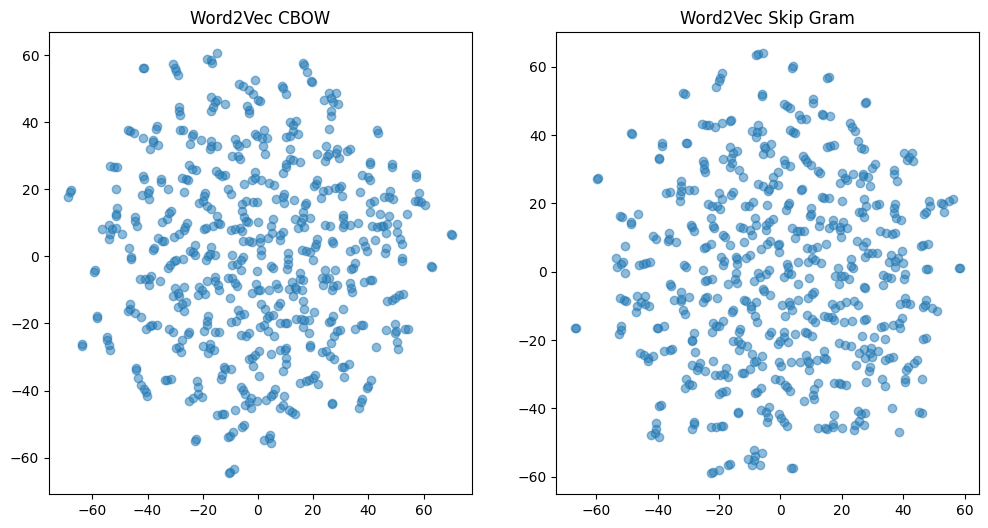

In [163]:
# Get all the word vectors
wordvectorscbow = modelcbow.wv[modelcbow.wv.key_to_index]
wordvectorsskipgram = modelskipgram.wv[modelskipgram.wv.key_to_index]



# 2D plotting using t-SNE
tsne = TSNE(n_components=2, perplexity=5)  
tsnecbow = tsne.fit_transform(wordvectorscbow)
tsneskipgram = tsne.fit_transform(wordvectorsskipgram)


# Plot using t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(tsnecbow[:, 0], tsnecbow[:, 1], alpha=0.5)
plt.title('Word2Vec CBOW')
plt.subplot(1, 2, 2)
plt.scatter(tsneskipgram[:, 0], tsneskipgram[:, 1], alpha=0.5)
plt.title('Word2Vec Skip Gram')
plt.show()

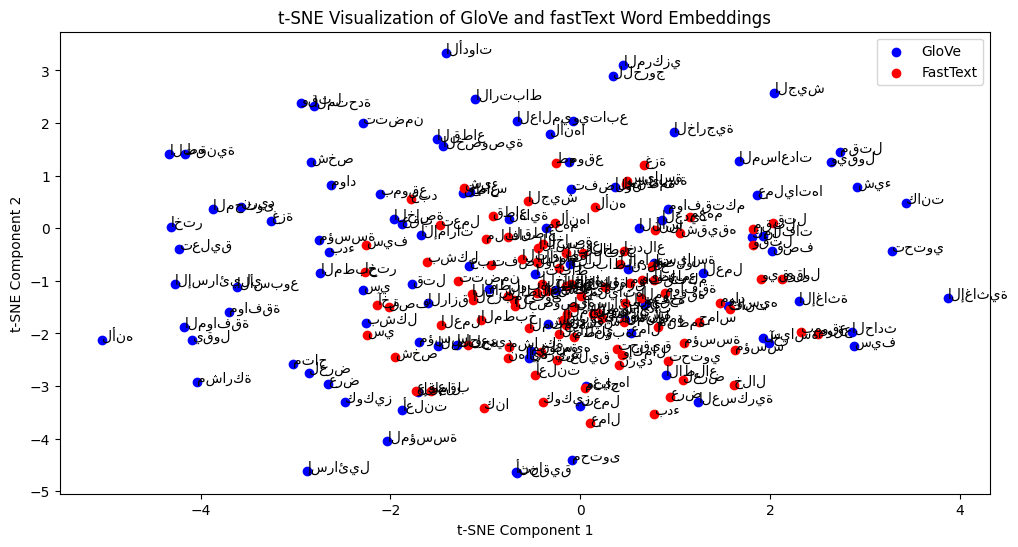

In [175]:
# Select a subset of words for visualization (you can use model.wv.index_to_key to get a list of words)
words_glove = list(modelglove.wv.index_to_key)[:100]  # Top 100 words
words_fasttext = list(modelfasttext.wv.index_to_key)[:100]  # Top 100 words

# Extract word vectors
vectors_glove = np.array([modelglove.wv[word] for word in words_glove])
vectors_fasttext = np.array([modelfasttext.wv[word] for word in words_fasttext])

# Set up t-SNE parameters
tsne_model = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

# Apply t-SNE to GloVe vectors
tsne_vectors_glove = tsne_model.fit_transform(vectors_glove)

# Apply t-SNE to fastText vectors
tsne_vectors_fasttext = tsne_model.fit_transform(vectors_fasttext)

# Plot GloVe results
plt.figure(figsize=(12, 6))
plt.scatter(tsne_vectors_glove[:, 0], tsne_vectors_glove[:, 1], c='blue', label='GloVe')
for i, word in enumerate(words_glove):
    plt.annotate(word, (tsne_vectors_glove[i, 0], tsne_vectors_glove[i, 1]))

# Plot fastText results
plt.scatter(tsne_vectors_fasttext[:, 0], tsne_vectors_fasttext[:, 1], c='red', label='FastText')
for i, word in enumerate(words_fasttext):
    plt.annotate(word, (tsne_vectors_fasttext[i, 0], tsne_vectors_fasttext[i, 1]))

# Add labels and legend
plt.title("t-SNE Visualization of GloVe and fastText Word Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

### Conclusion :

One-hot encoding and Bag of Words methods offer simple, interpretable vector representations but may lack nuanced semantic relationships. TF-IDF improves on these by providing term importance in the context of the dataset, giving more significance to key terms. Word2Vec, including Skip Gram and CBOW models, captures deeper semantic relationships and context in the text, providing more useful and dense representations. GloVe and FastText further enhance semantic representation and address out-of-vocabulary issues, with FastText particularly excelling at representing sub-word structures.

After visualizing the vectors with t-SNEweou can assess the effectiveness of each technique in terms of how well the different approaches can cluster and differentiate the data. Generally, Word2Vec, GloVe, and FastText methods often produce more coherent and semantically meaningful clusters compared to traditional methods like one-hot encoding and Bag of Words. This evaluation helps identify the most effective approaches for future tasks involving similar Arabic text data.